In [1]:
import math
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb #############
import lightgbm as lgb#############
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas_datareader.data as web

from matplotlib import style
from pandas import Series, DataFrame

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 8, 31)

In [3]:
# company = input("Enter the company name: ")
company = "MSFT"
df = web.DataReader(company, "yahoo", start, end)
print(df.head())
print(df.tail())
print()
print(df.shape[0])
days = df.shape[0]

close_px = df["Adj Close"]

                 High        Low       Open      Close      Volume  Adj Close
Date                                                                         
2010-01-04  31.100000  30.590000  30.620001  30.950001  38409100.0  24.443624
2010-01-05  31.100000  30.639999  30.850000  30.959999  49749600.0  24.451517
2010-01-06  31.080000  30.520000  30.879999  30.770000  58182400.0  24.301458
2010-01-07  30.700001  30.190001  30.629999  30.450001  50559700.0  24.048725
2010-01-08  30.879999  30.240000  30.280001  30.660000  51197400.0  24.214581
                  High         Low        Open       Close      Volume  \
Date                                                                     
2019-08-26  135.559998  133.899994  134.990005  135.449997  20312600.0   
2019-08-27  136.720001  134.660004  136.389999  135.740005  23102100.0   
2019-08-28  135.759995  133.550003  134.880005  135.559998  17393300.0   
2019-08-29  138.440002  136.910004  137.250000  138.119995  20168700.0   
2019-08-30

## Calculate various moving averages

In [4]:
start_50 = datetime.datetime(2009, 10, 22)
end_50 = datetime.datetime(2019, 8, 31)
df_50 = web.DataReader(company, "yahoo", start_50, end_50)
close_px_50 = df_50["Adj Close"]
movavg_50 = close_px_50.rolling(window=50).mean()
days_50 = len(movavg_50) - movavg_50.isna().sum()

while days_50 != days:
    if days_50 < days:
        start_50 = start_50 - datetime.timedelta(days=1)
    else:
        start_50 = start_50 + datetime.timedelta(days=1)
    
    df_50 = web.DataReader(company, "yahoo", start_50, end_50)
    close_px_50 = df_50["Adj Close"]
    movavg_50 = close_px_50.rolling(window=50).mean()
    days_50 = len(movavg_50) - movavg_50.isna().sum()

start_100 = datetime.datetime(2009, 8, 12)
end_100 = datetime.datetime(2019, 8, 31)
df_100 = web.DataReader(company, "yahoo", start_100, end_100)
close_px_100 = df_100["Adj Close"]
movavg_100 = close_px_100.rolling(window=100).mean()
days_100 = len(movavg_100) - movavg_100.isna().sum()

while days_100 != days:
    if days_100 < days:
        start_100 = start_100 - datetime.timedelta(days=1)
    else:
        start_100 = start_100 + datetime.timedelta(days=1)
        
    df_100 = web.DataReader(company, "yahoo", start_100, end_100)
    close_px_100 = df_100["Adj Close"]
    movavg_100 = close_px_100.rolling(window=100).mean()
    days_100 = len(movavg_100) - movavg_100.isna().sum()


start_200 = datetime.datetime(2009, 3, 20)
end_200 = datetime.datetime(2019, 8, 31)
df_200 = web.DataReader(company, "yahoo", start_200, end_200)
close_px_200 = df_200["Adj Close"]
movavg_200 = close_px_200.rolling(window=200).mean()
days_200 = len(movavg_200) - movavg_200.isna().sum()

while days_200 != days:
    if days_200 < days:
        start_200 = start_200 - datetime.timedelta(days=1)
    else:
        start_200 = start_200 + datetime.timedelta(days=1)
        
    df_200 = web.DataReader(company, "yahoo", start_200, end_200)
    close_px_200 = df_200["Adj Close"]
    movavg_200 = close_px_200.rolling(window=200).mean()
    days_200 = len(movavg_200) - movavg_200.isna().sum()
    
print(days_50)
print(days_100)
print(days_200)

2432
2432
2432


### Plot moving averages compared to each other and the closing prices

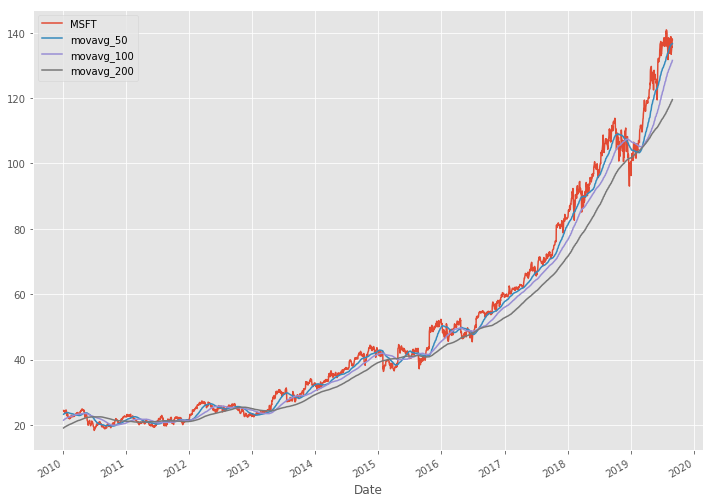

In [5]:
# Adjusting the size of the plot
mpl.rc("figure", figsize=(12, 9))
mpl.__version__

# Adjusting the style of the plot
style.use("ggplot")
close_px.plot(label=company)
movavg_50.plot(label="movavg_50")
movavg_100.plot(label="movavg_100")
movavg_200.plot(label="movavg_200")
plt.legend()

### Return Deviation - to determine risk and return

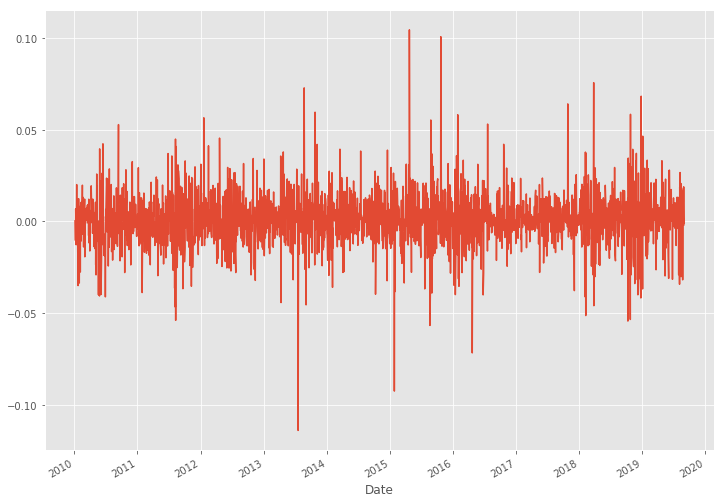

In [6]:
# Return = (closing_price / closing_price_last_day) - 1
returns = close_px / close_px.shift(1) - 1

returns.plot(label="return")

## Analysing the competitors stocks

In [7]:
df_competitors = web.DataReader([company, "GE", "GOOG", "IBM", "AAPL"], "yahoo", start=start, end=end)["Adj Close"]

In [8]:
print(df_competitors.head())
print(df_competitors.tail())

Symbols          AAPL         GE        GOOG        IBM       MSFT
Date                                                              
2010-01-04  26.681330  10.906911  312.204773  98.142967  24.443624
2010-01-05  26.727465  10.963388  310.829926  96.957375  24.451517
2010-01-06  26.302330  10.906911  302.994293  96.327530  24.301458
2010-01-07  26.253704  11.471671  295.940735  95.994110  24.048725
2010-01-08  26.428249  11.718755  299.885956  96.957375  24.214581
Symbols           AAPL    GE         GOOG         IBM        MSFT
Date                                                             
2019-08-26  206.490005  8.05  1168.890015  129.990005  135.449997
2019-08-27  204.160004  7.93  1167.839966  131.169998  135.740005
2019-08-28  205.529999  7.94  1171.020020  132.759995  135.559998
2019-08-29  209.009995  8.11  1192.849976  134.880005  138.119995
2019-08-30  208.740005  8.25  1188.099976  135.529999  137.860001


### Correlation Analysis - Does one competitor affect others?

In [9]:
returns_competitors = df_competitors.pct_change()

corr = returns_competitors.corr()

corr

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.321165,0.462883,0.385814,0.457645
GE,0.321165,1.000000,0.332437,0.437855,0.361893
GOOG,0.462883,0.332437,1.000000,0.406329,0.538604
IBM,0.385814,0.437855,0.406329,1.000000,0.491927
MSFT,0.457645,0.361893,0.538604,0.491927,1.000000


Text(0,0.5,'Return GE')

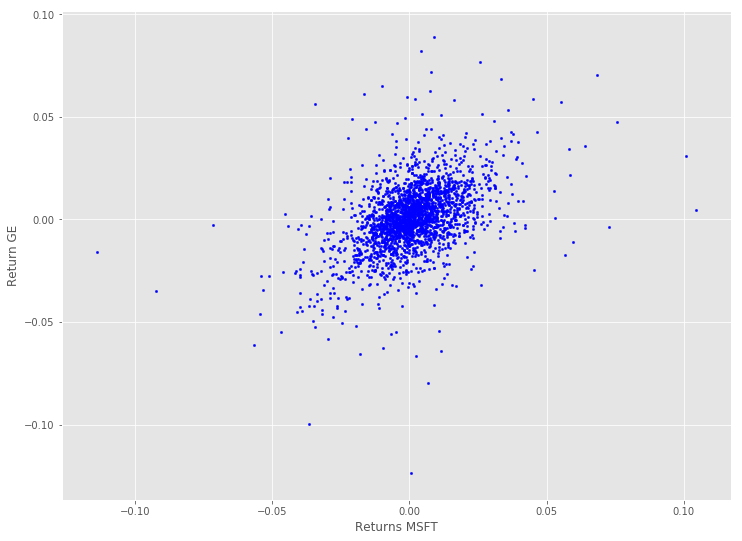

In [10]:
# plot the correlation of apple and microsoft
plt.scatter(returns_competitors.ix[:, 4], returns_competitors.ix[:, 0], color="blue", s=5)
plt.xlabel("Returns " + company)
plt.ylabel("Return GE")

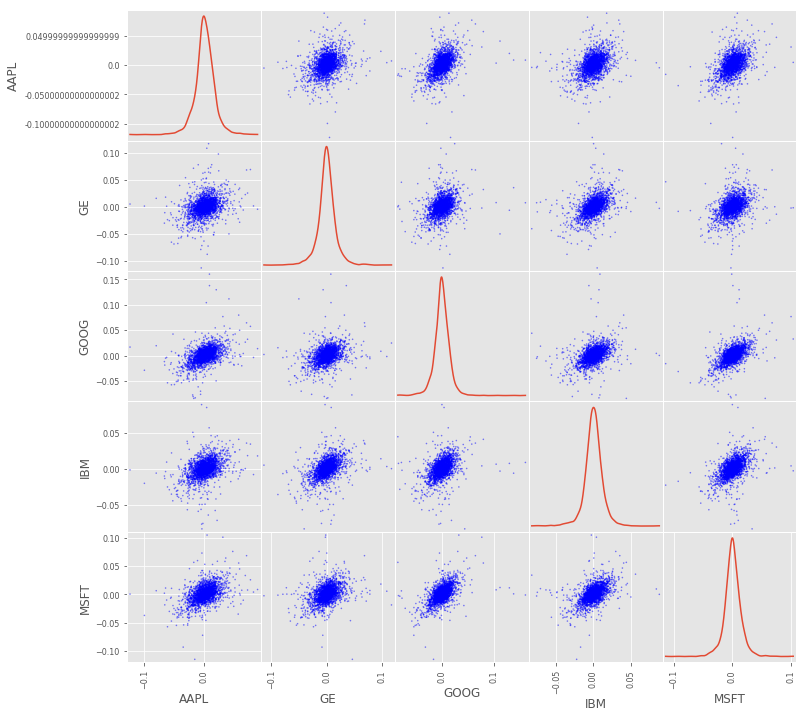

In [11]:
# plot a scatter matrix to visualize all correlations
pd.plotting.scatter_matrix(returns_competitors, diagonal="kde", figsize=(12, 12), s=10, color="blue");

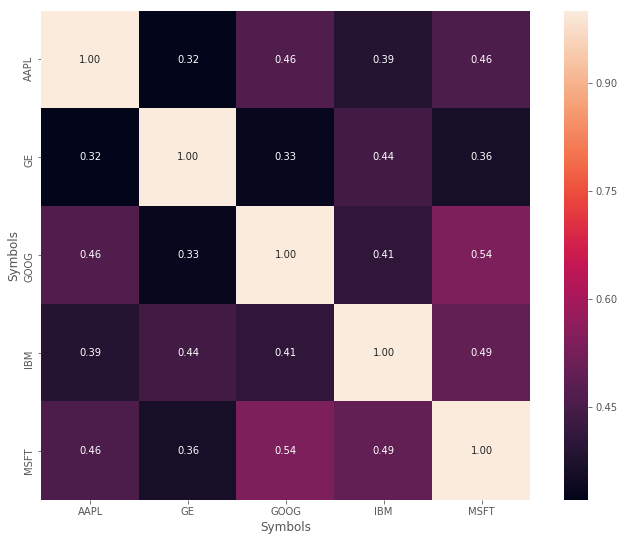

In [12]:
heatmap = sns.heatmap(corr, cbar=True, annot=True, fmt=".2f", annot_kws={"size": 10},
                     square=True, yticklabels=corr.columns, xticklabels=corr.columns)

## Stocks Returns Rate and Risk

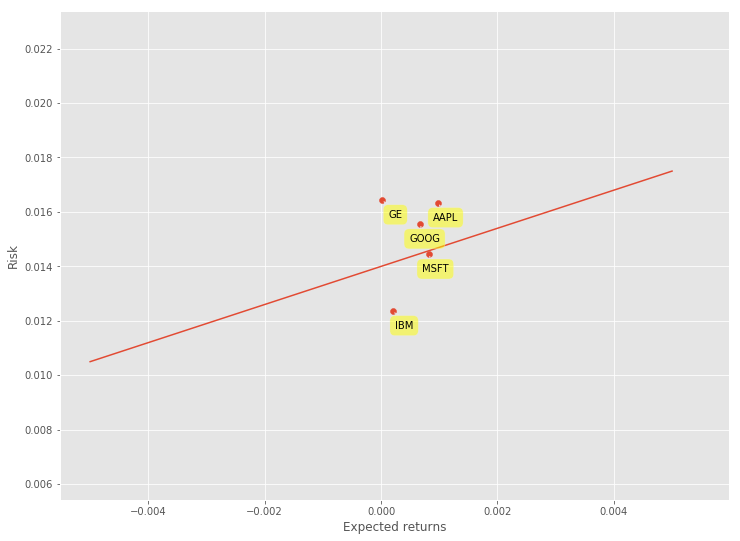

In [13]:
plt.scatter(returns_competitors.mean(), returns_competitors.std())
plt.xlabel("Expected returns")
plt.ylabel("Risk")

for label, x, y in zip(returns_competitors.columns, returns_competitors.mean(), returns_competitors.std()):
    plt.annotate(label, xy = (x, y), xytext = (20, -20), textcoords = 'offset points', ha = 'right',
                 va = 'bottom', bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                 arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

x = np.linspace(-0.005, 0.005, 100)
plt.plot(x, 0.7*x + 0.014, linestyle="solid")

#### sell stocks above red line and buy stocks below

# Predictings Stock Prices
## Feature Engineering

In [14]:
df_lr = df.loc[:, ["Adj Close", "Volume"]]
df_lr["HL_PCT"] = (df["High"] - df["Low"]) / df["Close"] * 100.0
df_lr["PCT_Change"] = (df["Close"] - df["Open"]) / df["Open"] * 100.0
df_lr["MovAvg50"] = movavg_50
df_lr["MovAvg100"] = movavg_100
df_lr["MovAvg200"] = movavg_200

df_lr.tail()

,Adj Close,Volume,HL_PCT,PCT_Change,MovAvg50,MovAvg100,MovAvg200
Date,,,,,,,
2019-08-26,135.449997,20312600.0,1.225547,0.340760,136.469736,130.789497,118.965528
2019-08-27,135.740005,23102100.0,1.517605,-0.476570,136.536354,130.961646,119.093088
2019-08-28,135.559998,17393300.0,1.630268,0.504146,136.553326,131.126732,119.220782
2019-08-29,138.119995,20168700.0,1.107732,0.633876,136.610933,131.317020,119.372008
2019-08-30,137.860001,23940100.0,2.110829,-0.927052,136.638223,131.511164,119.535225


## Pre-processing & Cross validation

1. Drop misssing values
2. Separte the label here, we only want to predict the AdjClose
3. Scale the X so that everyone can habe the same distribution for linear regression
4. Finally you want to find Data Series of late X and early X (train) for model generation and evaluation
5. Separate label and identify it as y
6. Sepation of training and testing of model by cross validation train test split

In [16]:
# 1.
df_lr.fillna(value=-99999, inplace=True)

# separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(df_lr)))

# 2.
forecast_column = "Adj Close"
df_lr["label"] = df_lr[forecast_column].shift(-forecast_out)
X = np.array(df_lr.drop(["label"], 1))

# 3.
X = preprocessing.scale(X)

# 4.
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# 5.
y = np.array(df_lr["label"])
y = y[:-forecast_out]

# 6 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Model Generation

## Testing various Regression models from SKLearn, LightGBM and XGBoost

In [17]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

def rmse_cv_train(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring=scorer, cv=10))
    return(rmse)

In [18]:
l1 = [0.00001, 0.00003, 0.00006, 0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60, 100]
l2 = [2, 3, 4, 5, 6, 7, 8, 9, 10]

### RidgeCV Regression

In [19]:
# best_score = 0
# best_alpha = 0
# scores = []

# for i in l1:
#     ridge = RidgeCV(alphas=[i])
#     ridge.fit(X_train, y_train)
#     score = ridge.score(X_test, y_test)
#     scores.append(score)
#     if score > best_score:
#         best_score = score
#         best_alpha = ridge.alpha_

# plt.plot(l1, scores)
# plt.xscale("log")

# print("Best alpha: ", best_alpha)
# print("Ridge Score on Training Set: ", best_score)

# ridge = RidgeCV(alphas=[best_alpha])
# ridge.fit(X_train, y_train)

### LassoCV Regression

In [20]:
# best_score = 0
# best_alpha = 0
# scores = []

# for i in l1:
#     lasso = LassoCV(alphas=[i], cv=5)
#     lasso.fit(X_train, y_train)
#     score = lasso.score(X_test, y_test)
#     scores.append(score)
#     if score > best_score:
#         best_score = score
#         best_alpha = lasso.alpha_

# plt.plot(l1, scores)
# plt.xscale("log")

# print("Best alpha: ", best_alpha)
# print("Lasso Score on Test Set: ", best_score)

# lasso = LassoCV(alphas=[best_alpha], cv=5)
# lasso.fit(X_train, y_train)

##### since RidgeCV and LassoCV will always perform equally or worse than ElasticNetCV we do not need to test them 

### ElasticNetCV Regression

In [21]:
best_score = 0
best_alpha = 0
best_cv = 0
best_l1_ratio = 0

scores = []

for j in l2:
    best_score = 0
    best_alpha = 0
    scores = []
    for i in l1:
        for k in [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1]:
            elasticNet = ElasticNetCV(l1_ratio=[k], alphas=[i], cv=j)
            elasticNet.fit(X_train, y_train)
            score = elasticNet.score(X_test, y_test)
            scores.append(score)
            if score > best_score:
                best_score = score
                best_alpha = i
                best_cv = j
                best_l1_ratio = k
#     print("Best alpha: ", best_alpha)
#     print("Ridge Score on Training Set: ", best_score)
#     print("Best CV: " + str(best_cv))
#     plt.plot(l1, scores)
#     plt.xscale("log")
#     plt.show()

    
print("Best alpha: ", best_alpha)
print("Elastic Net CV Score on Test Set: ", best_score)
print("Best CV: " + str(best_cv))
print("Best L1 Ratio: " + str(best_l1_ratio))

# plt.plot(l1, scores)
# plt.xscale("log")

elasticNet = ElasticNetCV(l1_ratio=[best_l1_ratio], alphas=[best_alpha], cv=best_cv)
elasticNet.fit(X_train, y_train)

Best alpha:  0.001
Elastic Net CV Score on Test Set:  0.9923287686487984
Best CV: 10
Best L1 Ratio: 0.3


ElasticNetCV(alphas=[0.001], copy_X=True, cv=10, eps=0.001,
       fit_intercept=True, l1_ratio=[0.3], max_iter=1000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

### KernelRidge Regression

In [22]:
best_score = 0
best_alpha = 0
best_coef0 = 0
best_degree = 0

scores = []
rounds_completed = 1

for j in [3, 4]:
    for k in [1, 2, 3, 5, 8, 10, 15, 20]:
        for i in l1:
            krr = KernelRidge(alpha=[i], kernel="polynomial", degree=j, coef0=k)
            krr.fit(X_train, y_train)
            score = krr.score(X_test, y_test)
            scores.append(score)
            if score > best_score:
                best_score = score
                best_alpha = i
                best_degree = j
                best_coef0 = k
    print("Round " + str(rounds_completed) + " completed!")
    rounds_completed += 1

print("Best alpha: " + str(best_alpha))
print("Kernel Ridge Score on Test Set: ", best_score)
print("Best degree: " + str(best_degree))
print("Best coef0: " + str(best_coef0))

krr = KernelRidge(alpha=[best_alpha], kernel="polynomial", degree=best_degree, coef0=best_coef0)
krr.fit(X_train, y_train)

Round 1 completed!
Round 2 completed!
Best alpha: 0.6
Kernel Ridge Score on Test Set:  0.9942981358826807
Best degree: 4
Best coef0: 20


KernelRidge(alpha=[0.6], coef0=20, degree=4, gamma=None, kernel='polynomial',
      kernel_params=None)

### GradientBoosting Regression

In [23]:
best_score = 0
best_n_estimators = 0
best_learning_rate = 0

scores = []
rounds_completed = 1
for j in [100, 250, 500, 1000, 2500, 5000]:
    for k in [0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.15]:
        GBoost = GradientBoostingRegressor(n_estimators=j, learning_rate=k,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=2, min_samples_split=2, 
                                   loss='huber', random_state=5)
        GBoost.fit(X_train, y_train)
        score = GBoost.score(X_test, y_test)
        scores.append(score)
        if score > best_score:
            best_score = score
            best_n_estimators = j
            best_learning_rate = k
    print("Round " + str(rounds_completed) + " completed")
    rounds_completed += 1
    
print("Gradient Boosting Score on Test Set: ", best_score)
print("Best learning_rate: " + str(best_learning_rate))
print("Best number of estimators: " + str(best_n_estimators))

GBoost = GradientBoostingRegressor(n_estimators=best_n_estimators, learning_rate=best_learning_rate,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=2, min_samples_split=2, 
                                   loss='huber', random_state=5)
GBoost.fit(X_train, y_train)
gboost_score = best_score

Round 1 completed
Round 2 completed
Round 3 completed
Round 4 completed
Round 5 completed
Round 6 completed
Gradient Boosting Score on Test Set:  0.9992028783856388
Best learning_rate: 0.03
Best number of estimators: 5000


### KNearestNeighbors Regression

In [24]:
best_score = 0
best_n_neighbors = 0
scores = []

for i in [1, 2, 3, 4, 5, 7, 9]:
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    scores.append(score)
    if score > best_score:
        best_score = score
        best_n_neighbors = i

print("Best number of neighbors: ", best_n_neighbors)
print("K Nearest Neighbors Score on Training Set: ", best_score)

knn = KNeighborsRegressor(n_neighbors=best_n_neighbors)
knn.fit(X_train, y_train)

Best number of neighbors:  5
K Nearest Neighbors Score on Training Set:  0.9909807499302539


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

## Average Models to get better results

In [25]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # define clones of ther original models to fit the data
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # train all cloned models
        for model in self.models_:
            model.fit(X, y)
            
        return self
    
    # predictions for cloned models
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)

In [26]:
# Models available: (RidgeCV, LassoCV,) ElasticNet, KernelRidgeRegression, GradientBoostingRegressor, KNearestNeighbors Regression
averaged_models_1 = AveragingModels(models=(elasticNet, krr, GBoost, knn))
averaged_models_1.fit(X_train, y_train)
print(averaged_models_1.score(X_test, y_test))

averaged_models_2 = AveragingModels(models=(elasticNet, krr, GBoost))
averaged_models_2.fit(X_train, y_train)
print(averaged_models_2.score(X_test, y_test))

averaged_models_3 = AveragingModels(models=(elasticNet, krr, knn))
averaged_models_3.fit(X_train, y_train)
print(averaged_models_3.score(X_test, y_test))

averaged_models_4 = AveragingModels(models=(elasticNet, GBoost, knn))
averaged_models_4.fit(X_train, y_train)
print(averaged_models_4.score(X_test, y_test))

averaged_models_5 = AveragingModels(models=(krr, GBoost, knn))
averaged_models_5.fit(X_train, y_train)
print(averaged_models_5.score(X_test, y_test))

# Because GBoost always performed the best on 10 different stock picks
# I try to mix it with only one of the other models
averaged_models_6 = AveragingModels(models=(GBoost, elasticNet))
averaged_models_6.fit(X_train, y_train)
print(averaged_models_6.score(X_test, y_test))

averaged_models_7 = AveragingModels(models=(GBoost, krr))
averaged_models_7.fit(X_train, y_train)
print(averaged_models_7.score(X_test, y_test))

averaged_models_8 = AveragingModels(models=(GBoost, knn))
averaged_models_8.fit(X_train, y_train)
print(averaged_models_8.score(X_test, y_test))

0.9963038283365668
0.9967385822746897
0.9942510103396681
0.9964668581069945
0.9968249981250378
0.9973369118659849
0.9978633452071471
0.9969536358171349


<p>Result: After testing 10 different stocks the result is that averaged models are not better than the Gradient Boosting Regressor alone.</p>
<p>Therefore I will only use the GradientBoosting Regressor to predict future stock prices.</p>

## Some Stock Forecasting

In [27]:
forecast_set = GBoost.predict(X_lately)
df_lr["Forecast"] = np.nan

# Results
print(forecast_set, gboost_score, forecast_out)

[136.93539165 135.87475947 133.88371912 134.61422586 135.4350126
 132.77916103 136.13288091 136.76230077 135.80878354 135.78283663
 136.30019914 135.60024652 134.88331597 135.02338505 135.61670808
 135.37124314 136.33591385 135.1010267  136.11317071 132.88662798
 137.4233093  136.82197623 137.67161428 135.93517473 135.26724301] 0.9992028783856388 25


# Plotting the Prediction

In [28]:
last_data = df_lr.iloc[-1].name
last_unix = last_data
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    df_lr.loc[next_date] = [np.nan for _ in range(len(df_lr.columns) - 1)] + [i]

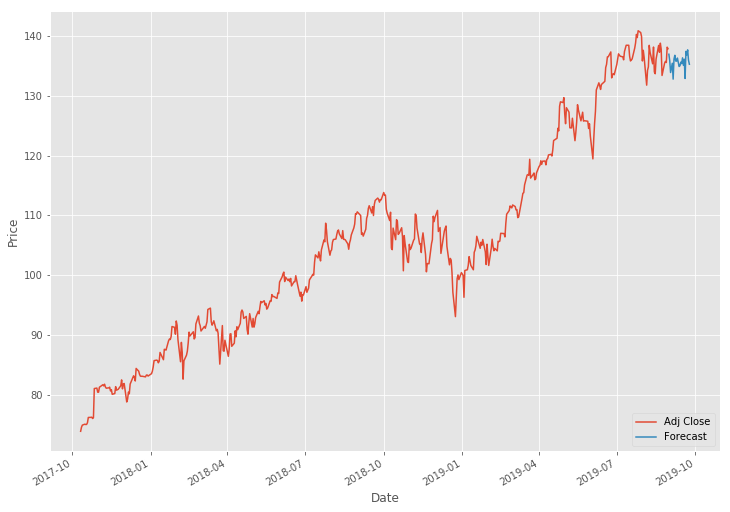

In [29]:
df_lr["Adj Close"].tail(500).plot()
df_lr["Forecast"].tail(500).plot()
plt.legend(loc=4)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()